## Setup

### Import + Utils

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
from darts import TimeSeries

print("NumPy:", np.__version__)  # Should be 1.26.4
print("Pandas:", pd.__version__)  # Should be 2.2.2

NumPy: 2.0.2
Pandas: 2.2.2


In [ ]:
print("darts:", pd.__version__)

darts: 2.2.2


In [148]:
from darts.models import Prophet, LinearRegressionModel, ARIMA,  ExponentialSmoothing, XGBModel,  NBEATSModel, GlobalNaiveAggregate, NaiveDrift
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import (
    InvertibleMapper,
    Mapper,
    MissingValuesFiller,
    Scaler,
    Diff
)
from darts.metrics import mape, rmse, mase, r2_score, mae, smape
from darts import concatenate
from darts.dataprocessing.transformers import MinTReconciliator, BottomUpReconciliator, TopDownReconciliator
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler

In [ ]:
from pandas import Timestamp
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

#### Pipeline

In [ ]:
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

global is_transformed
is_transformed = False

In [ ]:
def score_function(row):
    return (row['yearly_sMAPE'] +
            (row['yearly_R2'] * -0.5) +
            (row['max_quarterly_RMSE'] * 0.5) +
            (row['max_quarterly_RMSE'] * 0.5) +
            row['yearly_RMSE'])

In [ ]:
def get_winners(df, val):
    # Ensure indices align
    df = df.set_index('Date')
    if isinstance(val, TimeSeries):
        val = val.to_series()
    val = val.reindex(df.index)
    df['Actuals'] = val

    # Add quarter/year info
    df['Quarter'] = df.index.quarter
    df['Year'] = df.index.year

    quarterly_results = []

    # Group by model and quarter
    for (model_name, quarter), group in df.groupby(['Name', 'Quarter']):
        pred = TimeSeries.from_series(group['Predictions'])
        true = TimeSeries.from_series(group['Actuals'])

        # Compute metrics for this model+quarter
        mae_val = mae(true, pred)
        smape_val = smape(true, pred)
        rmse_val = rmse(true, pred)
        r2_val = r2_score(true, pred)

        quarterly_results.append({
            'Model': model_name,
            'Quarter': f'Q{quarter}',
            'MAE': mae_val,
            'sMAPE': smape_val,
            'RMSE': rmse_val,
            'R2': r2_val
        })

    quarterly_df = pd.DataFrame(quarterly_results)

    yearly_stats = []
    for model_name in df['Name'].unique():
        model_mask = df['Name'] == model_name
        pred = TimeSeries.from_series(df[model_mask]['Predictions'])
        true = TimeSeries.from_series(df[model_mask]['Actuals'])

        yearly_stats.append({
            'Model': model_name,
            'yearly_RMSE': rmse(true, pred),
            'yearly_MAE': mae(true, pred),
            'yearly_R2': r2_score(true, pred),
            'yearly_sMAPE': smape(true, pred)
        })

    yearly_df = pd.DataFrame(yearly_stats)

    # Calculate quarterly aggregates
    quarterly_agg = quarterly_df.groupby('Model').agg({
        'RMSE': ['mean', 'var', 'max'],
        'sMAPE': ['mean', 'var', 'max']
    })

    # Flatten multi-index columns
    quarterly_agg.columns = [
        'avg_quarterly_RMSE', 'var_quarterly_RMSE', 'max_quarterly_RMSE',
        'avg_quarterly_sMAPE', 'var_quarterly_sMAPE', 'max_quarterly_sMAPE'
    ]
    quarterly_agg = quarterly_agg.reset_index()

    # Merge all stats
    summary_df = pd.merge(yearly_df, quarterly_agg, on='Model')



    return quarterly_df,  summary_df

In [ ]:
def get_inflation(past_cov):
    #yearly global inflation data from world bank, potential extra explanatory variable for model
    inflation = pd.read_excel('globalinflation.xlsx')
    inflation = inflation.T
    inflation.index = pd.to_datetime(inflation.index, format='%Y')

    # data is yearly, make it monthly
    start_date = inflation.index.min()
    end_date = min(inflation.index.max() + pd.DateOffset(months=11),past_cov.time_index.max() )
    date_range = pd.date_range(start=start_date, end=end_date, freq='MS')
    inflation = inflation.reindex(date_range)
    #inflation = inflation.ffill()
    inflation = inflation.interpolate(method="linear")
    inflation = inflation.reset_index()
    inflation.columns = ["Date","inflation_rate"]

    # now can be used in past_cov
    return past_cov.stack(TimeSeries.from_dataframe(inflation, time_col="Date", value_cols="inflation_rate"))

In [ ]:
def apply_transformations(series, target, operations):
    global is_transformed
    is_transformed = True
    #establish data tranformations pipeline
    #modify Pipeline()s as needed
    yeojohnson = Scaler(PowerTransformer(method='yeo-johnson'))
    robustscaler = Scaler(RobustScaler())
    firstdiff = Diff(lags=1)
    #after brief check, monthly diff is the only one that improves things, but only some models and not by much
    #yeo johnson was similar. helped some in some cases but not as much as hoped :(
    monthlydiff = Diff(lags=12)
    quarterlydiff = Diff(lags=4)
    unitransformer = Pipeline([yeojohnson])
    multitransformer = Pipeline([yeojohnson])
    #transform data, can use a more complex pipeline later using pipeline() builtin from darts
    unitransformer.fit(target)
    multitransformer.fit(series)
    target = unitransformer.transform(target)
    series = multitransformer.transform(series)
    return series, target, unitransformer, multitransformer

In [ ]:
def load_data(file_path='SampleHierForecastingBASF_share.xlsx'):
  df = pd.read_excel(file_path)
  df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%y')
  df = df.sort_values(by='Date')
  numeric_cols = ['EBIT', 'EBITDA', 'DepreciationAmortization', 'VariableCosts', 'NetSales', 'ContributionMargin1', 'FixCosts']
  df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
  return df


#log scaling too?

In [ ]:
#not really confident this is performing like it should be. will look at later.
#maybe problem is fh? look at slides to pick good fh

def backtestmodels(fittedmodels, data, fh = 12, past_cov = None, retrain=True, start=pd.Timestamp('2022-01-01'), train_length=24, stride=3, plot=True):
  backtest_results_dict = {}
  for model_name, model in fittedmodels.items():
    kwargs = {
                'series': data,
                'start': start,
                'forecast_horizon': fh,
                'stride': stride,
                'retrain': retrain,
                'last_points_only': True,
                'verbose': False,
                'overlap_end' : True
            }
    if model.supports_past_covariates and past_cov:
      kwargs['past_covariates'] = past_cov

    backtested = model.historical_forecasts(**kwargs)
    backtest_results_dict[model_name+', backtested'] = backtested

  get_metrics_batched(backtest_results_dict, data['EBIT'])

  if plot:
        for model_name, forecast in backtest_results_dict.items():
            print(f"{model_name} - first forecast time: {forecast[0].start_time()}")
            forecast[0].plot(label=model_name)
        data['EBIT'].plot(label='Actual')
        plt.legend()
        plt.show()
  return backtest_results_dict



In [ ]:
def compare_models_multivariate(data, val, models):
  fittedmodels = {}
  predictions = {}
  for m in models:
    model_name = re.match(r"^([A-Za-z0-9_]+)\(", str(m)).group(1)
    m.fit(data)
    pred = m.predict(n=len(val))
    fittedmodels[model_name]=m
    predictions[model_name]=pred
  for_testing = {k:v['EBIT'] for k,v in predictions.items()}
  get_metrics_batched(for_testing, val['EBIT'])
  return fittedmodels, predictions

In [104]:
import re
def compare_models_univariate(data, val, models, past_cov=None):
  """
    Evaluate multiple forecasting models. supports univariate and multivariate models.
    Note that this doesn't currently work with reconciliation. Do not pass data with hierarchy implemented.

    Args:
        data: Training data TimeSeries. Should consist of only target variable.
        val: Validation period time series, includes target and past_covariates
        past_covariates: Hierarchical covariates, only require

    Returns:
        Two dictionaries:
        - fitted_models: {model_name: trained_model}
        - predictions: {model_name: forecast_series}

    Example:
        >>> models = [AutoARIMA(), XGBModel(lags=12)]
        >>> fitted, preds = compare_models_simple(train, val, covariates, models)
    """
  #check performance of passed models on data, return all fitted models in case of future evaluation needs
  fittedmodels = {}
  predictions = {}
  for m in models:
    model_name = re.match(r"^([A-Za-z0-9_]+)\(", str(m)).group(1)+', Uni'
    if m.supports_past_covariates and past_cov:
      m.fit(data, past_covariates=past_cov)
      pred = m.predict(n=len(val), past_covariates=past_cov)
    else:
      m.fit(data)
      pred = m.predict(n=len(val))
    fittedmodels[model_name]=m
    predictions[model_name]=pred
  get_metrics_batched(predictions, val)
  return fittedmodels, predictions

In [154]:
def compare_models_reconciliated(data, val, models, reconciliators, reconciliator_names):
  """
    Evaluate multiple multivariate forecasting models with hierarchies.
    Compare performance with and without reconciliation.
    Unreconciled predictions should perform worse than in the simple models method becuase the model doesn't know which var is target during training.

    Args:
        data: Training data TimeSeries
        val: Validation period time series
        models: a dictionary of fitted models

    Returns:
        Two dictionaries:
        - reconciled_predictions: {model_name: forecast_series}

    Example:
        >>> models = [AutoARIMA(), XGBModel(lags=12)]
        >>> fitted, preds = compare_models_simple(train, val, covariates, models)
    """
  reconciled_predictions={}
  for k,v in models.items():
    print(f"Testing {k}")
    for i in range(len(reconciliators)):
      reconciled_predictions[k+", "+reconciliator_names[i]] = reconciliators[i].transform(v)
  for_testing = {k:v['EBIT'] for k,v in reconciled_predictions.items()}
  get_metrics_batched(for_testing, val['EBIT'])
  return reconciled_predictions

In [146]:
def get_best_per_series(data, val, models, past_cov=None):
  """
    Evaluate multiple forecasting models. supports univariate and multivariate models.
    Note that this doesn't currently work with reconciliation. Do not pass data with hierarchy implemented.

    Args:
        data: Training data TimeSeries. Should consist of only target variable.
        val: Validation period time series, includes target and past_covariates
        past_covariates: Hierarchical covariates, only require

    Returns:
        Two dictionaries:
        - fitted_models: {model_name: trained_model}
        - predictions: {model_name: forecast_series}

    Example:
        >>> models = [AutoARIMA(), XGBModel(lags=12)]
        >>> fitted, preds = compare_models_simple(train, val, covariates, models)
    """
  #check performance of passed models on data, return all fitted models in case of future evaluation needs
  best = {}
  for s in data.components:
    predictions = {}
    rmse_scores = {}
    for m in models:
      model_name = re.match(r"^([A-Za-z0-9_]+)\(", str(m)).group(1)
      if m.supports_past_covariates and past_cov:
          m.fit(data[s], past_covariates=past_cov)
          pred = m.predict(n=len(val[s]), past_covariates=past_cov)
      else:
          m.fit(data[s])
          pred = m.predict(n=len(val[s]))
      predictions[model_name]=pred
      rmse_scores[model_name]=rmse(pred,val[s])    
    best_for_series = min(rmse_scores.items(), key=lambda x: x[1])[0]
    print(f"{s}: {best_for_series}")
    best[s]=predictions[best_for_series]
  if len(best) == 1:
      return best[0]
  else:
      temp = best['EBIT']
      for s,pred in best.items():
        if s != 'EBIT':
          temp = temp.concatenate(pred,axis=1)
      return temp

In [ ]:
def get_metrics(pred, val, name):
  """
    Standardized performance metrics to evaluate model performance. Consider additional metrics as well.

    Args:
        pred: Predicted time series from model
        val: Validation period time series, should be same shape as pred
        name: Name of model as String

    """
  print(f"MAE for {name}: {mae(val,pred):.2f}")
  print(f"MAPE for {name}: {mape(val,pred):.2f}")
  print(f"RMSE for {name}: {rmse(val, pred):.2f}")
  print(f"R^2 for {name}: {r2_score(val, pred):.2f}")
  print(f"SMAPE for {name}: {smape(val, pred):.2f}")

  print()

In [ ]:
def get_metrics_batched(preds,val, listlength=3, target='EBIT'):
  """
    Standardized performance metrics to evaluate model performance. Consider adding performance evaluations accross models (ie get best performing)

    Args:
        preds: Dictionary of form name of model : predicted time series from model
        val: Validation period time series

    """
  values = {}

  for key in preds:
    s=preds[key]
    curr_mae=mae(val,s)
    print(f"MAE for {key}: {curr_mae:.2f}")
    curr_mape=mape(val,s)
    print(f"MAPE for {key}: {curr_mape:.2f}")
    curr_rmse=rmse(val, s)
    print(f"RMSE for {key}: {curr_rmse:.2f}")
    print(f"R^2 for {key}: {r2_score(val, s):.2f}")
    print(f"SMAPE for {key}: {smape(val, s):.2f}")
    values[key]={'MAE': curr_mae,
                           'MAPE': curr_mape,
                           'RMSE':curr_rmse}

    print()
  sorted_models = sorted(values.items(), key=lambda x: x[1]['RMSE'])
  sorted_models = sorted_models[:listlength]
  return dict(sorted_models)


#### Implementing Hierarchy

In [ ]:
def get_levels(ts):
  hierarchy = ts.hierarchy
  reversed = {}
  for key, value in ts.hierarchy.items():
    if value[0] in reversed:
      reversed[value[0]].append(key)
    else:
      reversed[value[0]] = [key]
  return reversed

In [100]:
def apply_hierarchy(df, hvar = 'v0'):
  """assumes data is in format from given sheet. change this to work with other datasets"""
  if hvar == 'v1':
    hierarchy = {
          'EBIT': ['EBITDA'],
          '-DepreciationAmortization': ['EBITDA']
      }
    cols = ["EBITDA", "-DepreciationAmortization"]
  elif hvar == 'v2':
    hierarchy = {
          'ContributionMargin1': ['EBIT'],
          '-FixCosts': ['EBIT'],
          'NetSales': ['ContributionMargin1'],
          '-VariableCosts': ['ContributionMargin1']
      }
    cols = ["ContributionMargin1", "-FixCosts", "NetSales", "-VariableCosts"]
  else:
    hierarchy = {
          'EBIT': ['EBITDA'],
          '-DepreciationAmortization': ['EBITDA'],
          'ContributionMargin1': ['EBIT'],
          '-FixCosts': ['EBIT'],
          'NetSales': ['ContributionMargin1'],
          '-VariableCosts': ['ContributionMargin1']
      }
    cols = ["EBITDA", "-DepreciationAmortization", "ContributionMargin1", "-FixCosts", "NetSales", "-VariableCosts"]

  if isinstance(df, pd.DataFrame):
    df['-VariableCosts'] = -df['VariableCosts']
    df['-FixCosts'] = -df['FixCosts']
    df['-DepreciationAmortization'] = -df['DepreciationAmortization']
    series = TimeSeries.from_dataframe(df, time_col="Date", value_cols=cols+['EBIT'])
    series = series.with_hierarchy(hierarchy)
    target = series["EBIT"]
    covariates = series[cols]

  elif isinstance(df, TimeSeries):
    series = df[cols+['EBIT']].with_hierarchy(hierarchy)
    target = series["EBIT"]
    covariates = series[cols]

  else:
    raise TypeError("df must be a pandas DataFrame or TimeSeries")

  return series, target, covariates, hierarchy

# Models

### Setup for Model Comparison

In [102]:
df = load_data()
series, target, covariates, hierarchy = apply_hierarchy(df, hvar='v0')
#series, target, unitransformer, multitransformer = apply_transformations(series, target,[])

train, val = target[:-24], target[-24:-12]
past_cov = covariates[:-12]

#### Adding Covariates

In [ ]:
#past_cov = get_inflation(past_cov)

In [ ]:
#add lag features to past_cov as well?

### Baseline Model Comparison

In [127]:
#get baseline performance, 2022 is validation year
#don't run with covariates! it will break and you will be sad.
models_to_test = [
    ARIMA(q=1),
    ExponentialSmoothing(),
    Prophet(),
    #NBEATSModel(input_chunk_length=36,output_chunk_length=24, dropout= 0.11891699976631348, n_epochs=27, batch_size=128),
    #LinearRegressionModel(lags=12, lags_past_covariates=12),
    LinearRegressionModel(lags=12),
    #XGBModel(lags=12, lags_past_covariates=12),
    XGBModel(lags=12)
    ]

fittedbaselinemodels, univariate_predictions = compare_models_univariate(train, val, models_to_test, past_cov)


MAE for ARIMA, Uni: 10593.30
sMAPE for ARIMA, Uni: 81.98
RMSE for ARIMA, Uni: 12526.19
R2 for ARIMA, Uni: 0.80

MAE for ExponentialSmoothing, Uni: 9987.80
sMAPE for ExponentialSmoothing, Uni: 84.67
RMSE for ExponentialSmoothing, Uni: 11312.62
R2 for ExponentialSmoothing, Uni: 0.83

MAE for Prophet, Uni: 12980.65
sMAPE for Prophet, Uni: 117.49
RMSE for Prophet, Uni: 16242.64
R2 for Prophet, Uni: 0.66

MAE for LinearRegression, Uni: 10010.87
sMAPE for LinearRegression, Uni: 78.46
RMSE for LinearRegression, Uni: 12464.43
R2 for LinearRegression, Uni: 0.80

MAE for XGBRegressor, Uni: 10149.12
sMAPE for XGBRegressor, Uni: 85.88
RMSE for XGBRegressor, Uni: 13095.70
R2 for XGBRegressor, Uni: 0.78



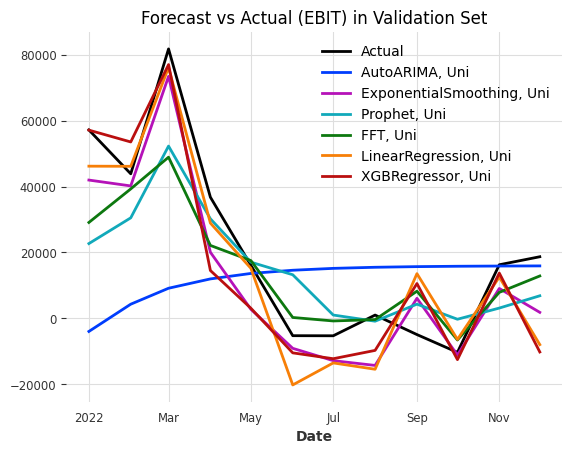

In [106]:
if is_transformed:
    val = unitransformer.inverse_transform(val)
    #how did we perform? unscale data to find out
    val.plot(label="Actual")
    for name, forecast in univariate_predictions.items():
        temp = unitransformer.inverse_transform(forecast['EBIT'])
        temp.plot(label=name)
        plt.title("Forecast vs Actual (EBIT) in validation set")
        get_metrics(temp, val, name)

else:
    val.plot(label="Actual")
    for name, forecast in univariate_predictions.items():
        forecast.plot(label=name)
        plt.title("Forecast vs Actual (EBIT) in Validation Set")
        #get_metrics(forecast, val, name)

In [107]:
#get reconciliated performance compared to baseline multivariate, 2022 is validation year
hierarchical_train = series[:-24]
hierarchical_val = series[-24:-12]

models_to_test = [

    NBEATSModel(input_chunk_length=36,output_chunk_length=24, dropout= 0.11891699976631348, n_epochs=27, batch_size=128),
    LinearRegressionModel(lags=12),
    XGBModel(lags=12)
    ]

reconciliator0 = MinTReconciliator(method="ols")
reconciliator0.fit(series[:-24])
reconciliator1 = TopDownReconciliator()
reconciliator1.fit(series[:-24])
reconciliator2 = BottomUpReconciliator()
# reconciliator3 = MatrixReconciliation(hierarchy, method='bottom_up')
# reconciliator4 = MatrixReconciliation(hierarchy, method='top_down')

reconciliators = [reconciliator0,reconciliator1,reconciliator2,]
                  #reconciliator3,reconciliator4]
names = ['MiNT','Top Down', 'Bottom Up']
         #'Matrix Bottom Up', 'Matrix Top Down']

In [108]:
# unreconciled baseline models
unreconciled_models, unreconciled_predictions = compare_models_multivariate(hierarchical_train, hierarchical_val, models_to_test)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.77it/s]
NBEATSModel time: 7.06 seconds
LinearRegression time: 0.02 seconds
XGBRegressor time: 1.13 seconds
MAE for NBEATSModel: 16772.52
sMAPE for NBEATSModel: 115.98
RMSE for NBEATSModel: 22502.77
R2 for NBEATSModel: 0.34

MAE for LinearRegression: 10900.66
sMAPE for LinearRegression: 75.08
RMSE for LinearRegression: 13185.51
R2 for LinearRegression: 0.77

MAE for XGBRegressor: 11045.77
sMAPE for XGBRegressor: 97.72
RMSE for XGBRegressor: 13665.80
R2 for XGBRegressor: 0.76



In [151]:
models_to_test = [
    ARIMA(q=1),
    ExponentialSmoothing(),
    Prophet(),
    #NBEATSModel(input_chunk_length=36,output_chunk_length=24, dropout= 0.11891699976631348, n_epochs=27, batch_size=128),
    #LinearRegressionModel(lags=12, lags_past_covariates=12),
    LinearRegressionModel(lags=12),
    #XGBModel(lags=12, lags_past_covariates=12),
    #XGBModel(lags=12),
    NaiveDrift(),
    GlobalNaiveAggregate(input_chunk_length=3, output_chunk_length=3),
    GlobalNaiveAggregate(input_chunk_length=1, output_chunk_length=1),
    GlobalNaiveAggregate(input_chunk_length=12, output_chunk_length=12),
    ]
best_per_series = get_best_per_series(hierarchical_train, hierarchical_val,models=models_to_test)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.64it/s]
EBITDA: ExponentialSmoothing
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 195.21it/s]
-DepreciationAmortization: ARIMA
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 302.60it/s]
ContributionMargin1: Prophet
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 299.38it/s]
-FixCosts: Prophet
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 265.85it/s]
NetSales: LinearRegression
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 308.43it/s]
-VariableCosts: LinearRegression
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 247.31it/s]
EBIT: ExponentialSmoothing


In [156]:
best_per_series=best_per_series.with_hierarchy(hierarchy)

In [157]:
unreconciled_predictions['Per Series']=best_per_series

In [158]:
reconciliatedpredictions = compare_models_reconciliated(data=hierarchical_train, val=val['EBIT'], models=unreconciled_predictions, reconciliators=reconciliators, reconciliator_names=names)

Testing NBEATSModel
Testing LinearRegression
Testing XGBRegressor
Testing Per Series
MAE for NBEATSModel, MiNT: 12419.40
sMAPE for NBEATSModel, MiNT: 79.90
RMSE for NBEATSModel, MiNT: 15547.29
R2 for NBEATSModel, MiNT: 0.69

MAE for NBEATSModel, Top Down: 15420.89
sMAPE for NBEATSModel, Top Down: 102.99
RMSE for NBEATSModel, Top Down: 16689.54
R2 for NBEATSModel, Top Down: 0.64

MAE for NBEATSModel, Bottom Up: 27603.91
sMAPE for NBEATSModel, Bottom Up: 129.18
RMSE for NBEATSModel, Bottom Up: 29627.58
R2 for NBEATSModel, Bottom Up: -0.14

MAE for LinearRegression, MiNT: 8511.58
sMAPE for LinearRegression, MiNT: 77.32
RMSE for LinearRegression, MiNT: 11292.21
R2 for LinearRegression, MiNT: 0.83

MAE for LinearRegression, Top Down: 10456.90
sMAPE for LinearRegression, Top Down: 86.35
RMSE for LinearRegression, Top Down: 13296.15
R2 for LinearRegression, Top Down: 0.77

MAE for LinearRegression, Bottom Up: 10900.66
sMAPE for LinearRegression, Bottom Up: 75.08
RMSE for LinearRegression, Bot

### Model Training (Separate Series)

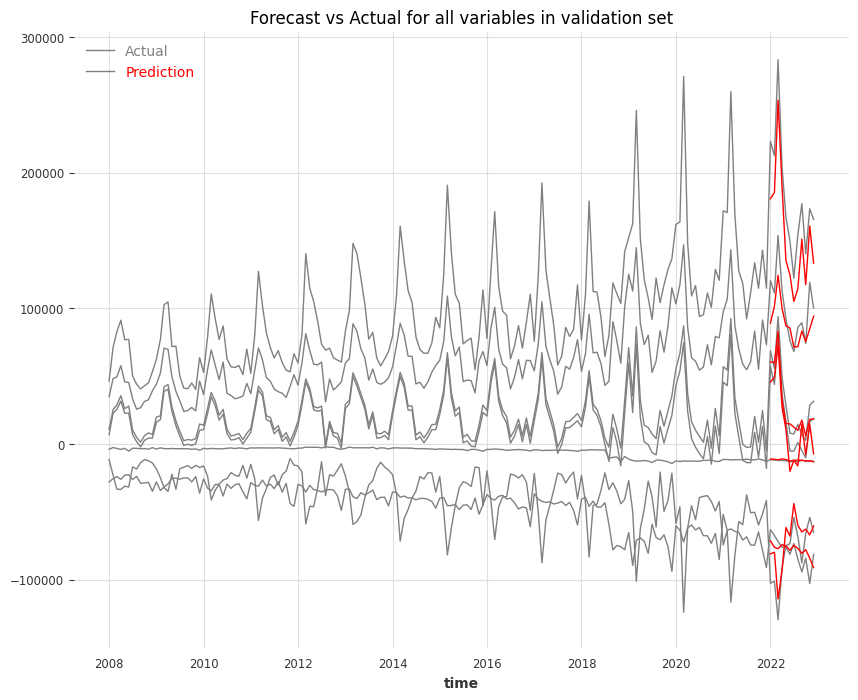

In [ ]:
#how did we do? plot to see
plt.figure(figsize=(10, 8))
#filter so we only show dates we actually calculated predictions for
filtered_series = series.drop_after(Timestamp('2022-12-31'))
filtered_series[list(forecasts_dict.keys())].plot(lw=1, color='gray', label='Actual')
for key, f in forecasts_dict.items():
    f.plot(lw=1, color='red', label=f'Predicted - {key}')  # Label with the key
plt.legend(["Actual", "Prediction"], loc="upper left", labelcolor=["gray","red"])
plt.title("Forecast vs Actual for all variables in validation set")
plt.show()

### Getting best models, consolidating metrics

In [159]:
merged={**unreconciled_predictions,
**reconciliatedpredictions,}

merged = {k:v['EBIT'] for k,v in merged.items()}

merged = {**univariate_predictions,}

In [ ]:
# Convert each TimeSeries to a DataFrame and combine
dfs = []
for model_name, ts in merged.items():
    # Extract dates and values
    df = ts.to_dataframe().reset_index()  # Converts to DataFrame with date and value
    df.columns = ["Date", "Predictions"]    # Rename columns
    df["Name"] = model_name          # Add model name column
    dfs.append(df)

# Combine all models' predictions
merged_df = pd.concat(dfs, ignore_index=True)

# Reorder columns: date, model_name, prediction
merged_df = merged_df[["Date", "Name", "Predictions"]]
merged_df['Date']=pd.to_datetime(merged_df['Date'])

In [ ]:
quarterly, summary = get_winners(merged_df,val['EBIT'])

In [ ]:
numeric = [c for c in summary.columns if c!='Model']
normalized_summary = summary.copy()
normalized_summary[numeric] = normalized_summary[numeric].apply(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0.5
    )

### I would really adjust this score function
normalized_summary['Score'] = normalized_summary.apply(score_function, axis=1)
final_ranking = (normalized_summary[['Model', 'Score']]
                .sort_values('Score')
                .reset_index(drop=True)
                .assign(Rank=lambda x: x.index + 1))